<a href="https://colab.research.google.com/github/FrancLis/Multivariate-Time-Series-Forecasting/blob/main/Hyperparameter_Tuning_Talos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook is shown the code used for some experiments of Hyperparameter tuning made using the library talos. In this case was used a RNN, but the experiments could have been run also with a GRU, LSTM and Conv1D. It's only necessary to change the parameters and the model built-in function

In [ ]:
!pip install talos
!pip install joblib

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

import seaborn as sns
import pandas as pd
import talos as ta
from numpy import zeros, newaxis
from matplotlib import pyplot as plt
from joblib import dump, load
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D, Flatten

## Hyperparameter Tuning

Load and read preprocessed data

In [ ]:
with open('Preprocessed_data_PG.npy', 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f)
    X_valid = np.load(f)
    y_valid = np.load(f)
    X_test = np.load(f)
    y_test = np.load(f)

print('All shapes are: (batch, time, features)')
print('X_train.shape:', X_train.shape, 'y_train.shape:', y_train.shape)
print('X_valid.shape:', X_valid.shape, 'y_valid.shape:', y_valid.shape)
print('X_test.shape:', X_test.shape, 'y_test.shape:', y_test.shape)

All shapes are: (batch, time, features)
X_train.shape: (10496, 20, 6) y_train.shape: (10496, 1)
X_valid.shape: (1294, 20, 6) y_valid.shape: (1294, 1)
X_test.shape: (1295, 20, 6) y_test.shape: (1295, 1)


Load scaler

In [ ]:
scaler = load('MinMaxScaler_PG.joblib')

It was verified through these lines of code that the two scales were equal

In [ ]:
# Those attributes are specific of MinMaxScaler. For other scalers they might change
# if (imported_scaler.scale_ == scaler.scale_).all() and (imported_scaler.data_max_ == scaler.data_max_).all() \
        # and (imported_scale.data_min_ == scaler.data_min_).all() and (imported_scale.data_range_ == scaler.data_range_).all():
   # print("Scalers are same")

It is necessary to import the shoe ladder then subsequently the new observations that the algorithm will predict in the future which will then be reused for the next prison prediction

In [ ]:
# from talos.utils import hidden_layers

The Hidden layers function has been imported from the Talos library but has been modified according to the needs of the project

In [ ]:
def network_shape_customized(params, last_neuron, network_type):

    '''Provides the ability to include network shape in experiments. If params
    dictionary for the round contains float value for params['shapes'] then
    a linear contraction towards the last_neuron value. The higher the value,
    the fewer layers it takes to reach lesser than last_neuron.
    Supports three inbuilt shapes 'brick', 'funnel', and 'triangle'.
    params : dict
         Scan() params for a single roundself.
    last_neuron : int
         Number of neurons on the output layer in the Keras model.
    '''
    import numpy as np
    from talos.utils.exceptions import TalosParamsError

    layers = params['hidden_layers']
    shape = params['shapes']
    # network_type == 0 --> SimpleRNN
    # network_type == 1 --> GRU
    # network_type == 2 --> LSTM
    # network_type == 3 --> CONV1D
    if network_type == 3:
      first_neuron = params['first_filter']
    else:
      first_neuron = params['first_neuron']

    out = []
    n = first_neuron

    # the case where hidden_layers is zero
    if layers == 0:
        return [0]

    # the cases where an angle is applied
    if isinstance(shape, float):

        for i in range(layers):

            n *= 1 - shape

            if n > last_neuron:
                out.append(int(n))
            else:
                out.append(last_neuron)

    # the case where a rectantular shape is used
    elif shape == 'brick':
        out = [first_neuron] * layers

    elif shape == 'funnel':
        for i in range(layers + 1):
            n -= int((first_neuron - last_neuron) / layers)
            out.append(n)
        out.pop(-1)

    elif shape == 'triangle':
        out = np.linspace(first_neuron,
                          last_neuron,
                          layers+2,
                          dtype=int).tolist()

        out.pop(0)
        out.pop(-1)
        out.reverse()

    else:
        message = "'shapes' must be float or in ['funnel', 'brick', 'triangle']"
        raise TalosParamsError(message)

    return out


def hidden_layers_customized(model, params, last_neuron, network_type):
    '''HIDDEN LAYER Generator

    NOTE: 'shapes', 'first_neuron', 'dropout', and 'hidden_layers' need
    to be present in the params dictionary.

    Hidden layer generation for the cases where number
    of layers is used as a variable in the optimization process.
    Handles things in a way where any number of layers can be tried
    with matching hyperparameters.'''

    # check for the params that are required for hidden_layers

    from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM
    # from .network_shape import network_shape
    from talos.utils.exceptions import TalosParamsError

    if network_type == 0:
      required = ['shapes', 'first_neuron', 'dropout', 'hidden_layers', 'rnn_units']
    elif network_type == 1:
      required = ['shapes', 'first_neuron', 'dropout', 'hidden_layers', 'gru_units']
    elif network_type == 2:
      required = ['shapes', 'first_neuron', 'dropout', 'hidden_layers', 'lstm_units']
    elif network_type == 3:
      required = ['shapes', 'first_filter', 'dropout', 'hidden_layers', 'kernel_size', 'activation', 'filter']



    for param in required:
        if param not in params:
            message = "hidden_layers requires '" + param + "' in params"
            raise TalosParamsError(message)

    layer_neurons = network_shape_customized(params, last_neuron, network_type)
    # network_type == 0 --> SimpleRNN
    # network_type == 1 --> GRU
    # network_type == 2 --> LSTM
    # network_type == 3 --> CONV1D

    if network_type == 0:
        for i in range(params['hidden_layers']):
            if params['hidden_layers'] == 0:
              model.add(SimpleRNN(layer_neurons[i], return_sequences=False, activation='relu'))
            else:
                if i == params['hidden_layers'] - 1:
                  model.add(SimpleRNN(layer_neurons[i], return_sequences=False, activation='relu'))
                else:
                  model.add(SimpleRNN(layer_neurons[i], return_sequences=True, activation='relu'))
    elif network_type == 1:
       for i in range(params['hidden_layers']):
            if params['hidden_layers'] == 0:
              model.add(SimpleRNN(layer_neurons[i], return_sequences=False, activation='relu'))
            else:
                if i == params['hidden_layers'] - 1:
                  model.add(SimpleRNN(layer_neurons[i], return_sequences=False, activation='relu'))
                else:
                  model.add(SimpleRNN(layer_neurons[i], return_sequences=True, activation='relu'))
    elif network_type == 2:
       for i in range(params['hidden_layers']):
            if params['hidden_layers'] == 0:
              model.add(SimpleRNN(layer_neurons[i], return_sequences=False, activation='elu'))
            else:
                if i == params['hidden_layers'] - 1:
                  model.add(SimpleRNN(layer_neurons[i], return_sequences=False, activation='elu'))
                else:
                  model.add(SimpleRNN(layer_neurons[i], return_sequences=True, activation='elu'))
    elif network_type == 3:
        for i in range(params['hidden_layers']):

            model.add(Conv1D(layer_neurons[i],
                            kernel_size=params.get('kernel_size'),
                            padding = 'same', activation='relu'))
            model.add(MaxPooling1D(pool_size=2, padding='same'))
            model.add(Dropout(params['dropout']))
    else:
      message = "Model not supported"
      raise TalosParamsError(message)



#### 3.1 Recurrent Neural Network (RNN)

In [ ]:
def rnn_fn(x_train, y_train, x_val, y_val, params):
	  # Step 1: reset the tensorflow backend session.
    tf.keras.backend.clear_session()
    # Step 2: Define the model with variable hyperparameters.
    # dropout = float(params['dropout'])
    # lr = float(params['lr'])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    hidden_layers_customized(model, params, 1, 0)
    model.add(tf.keras.layers.Dropout(0))
    model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.Activation('linear'))
    
    model.compile(
        loss='mse',
        optimizer = 'Adam'
        #params['optimiz'](learning_rate=lr),
        # metrics=['mse']
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    history = model.fit(
        x_train, y_train, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        verbose=0,
        validation_data=[x_val, y_val],
        callbacks=[stop_early], 
    )

    return history, model, 

para = {
    'batch_size': [70, 100], 
    'epochs': [100, 200],  # 100, 200
    'shapes': ['brick', 'triangle'],               # <<< required
    'first_neuron': [64, 32],  # 64,               # <<< required
    'hidden_layers': [2, 3, 4],  # 2, 3            # <<< required
     # 'dropout': [0],  # 0.25                        # <<< required
     # 'rnn_units': [32],  # 128                      # <<< required
     # 'optimiz': [Nadam, Adam],
     # 'lr': [0.001, 0.01, 0.1] 
}


  0%|          | 0/48 [00:00<?, ?it/s]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'brick'}


  2%|▏         | 1/48 [00:39<31:15, 39.90s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'triangle'}


  4%|▍         | 2/48 [01:02<22:38, 29.52s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'brick'}


  6%|▋         | 3/48 [01:36<23:54, 31.87s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'triangle'}


  8%|▊         | 4/48 [02:07<23:09, 31.57s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'brick'}


 10%|█         | 5/48 [02:55<26:38, 37.17s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'triangle'}


 12%|█▎        | 6/48 [03:31<25:45, 36.79s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'brick'}


 15%|█▍        | 7/48 [03:51<21:34, 31.56s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'triangle'}


 17%|█▋        | 8/48 [04:10<18:21, 27.54s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'brick'}


 19%|█▉        | 9/48 [04:39<18:03, 27.79s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'triangle'}


 21%|██        | 10/48 [05:04<17:11, 27.15s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'brick'}


 23%|██▎       | 11/48 [05:41<18:32, 30.05s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'triangle'}


 25%|██▌       | 12/48 [06:12<18:17, 30.48s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'brick'}


 27%|██▋       | 13/48 [06:58<20:23, 34.95s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'triangle'}


 29%|██▉       | 14/48 [07:41<21:09, 37.33s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'brick'}


 31%|███▏      | 15/48 [09:05<28:21, 51.56s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'triangle'}


 33%|███▎      | 16/48 [10:06<29:03, 54.49s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'brick'}


 35%|███▌      | 17/48 [11:39<34:02, 65.89s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'triangle'}


 38%|███▊      | 18/48 [12:47<33:16, 66.54s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'brick'}


 40%|███▉      | 19/48 [13:26<28:09, 58.26s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'triangle'}


 42%|████▏     | 20/48 [14:02<24:03, 51.57s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'brick'}


 44%|████▍     | 21/48 [14:55<23:29, 52.21s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'triangle'}


 46%|████▌     | 22/48 [15:44<22:09, 51.14s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'brick'}


 48%|████▊     | 23/48 [16:52<23:23, 56.14s/it]

{'batch_size': 500, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'triangle'}


 50%|█████     | 24/48 [17:51<22:46, 56.93s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'brick'}


 52%|█████▏    | 25/48 [18:13<17:51, 46.58s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'triangle'}


 54%|█████▍    | 26/48 [18:31<13:54, 37.91s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'brick'}


 56%|█████▋    | 27/48 [19:03<12:37, 36.07s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'triangle'}


 58%|█████▊    | 28/48 [19:27<10:50, 32.53s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'brick'}


 60%|██████    | 29/48 [20:11<11:25, 36.05s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 32, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'triangle'}


 62%|██████▎   | 30/48 [20:41<10:13, 34.06s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'brick'}


 65%|██████▍   | 31/48 [20:58<08:12, 28.96s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'triangle'}


 67%|██████▋   | 32/48 [21:13<06:39, 24.99s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'brick'}


 69%|██████▉   | 33/48 [21:36<06:04, 24.28s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'triangle'}


 71%|███████   | 34/48 [21:56<05:22, 23.06s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'brick'}


 73%|███████▎  | 35/48 [22:25<05:21, 24.75s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 50, 'first_neuron': 16, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'triangle'}


 75%|███████▌  | 36/48 [22:49<04:55, 24.64s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'brick'}


 77%|███████▋  | 37/48 [23:29<05:19, 29.04s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'triangle'}


 79%|███████▉  | 38/48 [24:11<05:31, 33.18s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'brick'}


 81%|████████▏ | 39/48 [25:11<06:09, 41.02s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'triangle'}


 83%|████████▎ | 40/48 [25:56<05:37, 42.18s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'brick'}


 85%|████████▌ | 41/48 [27:21<06:25, 55.09s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 32, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'triangle'}


 88%|████████▊ | 42/48 [28:16<05:31, 55.18s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'brick'}


 90%|████████▉ | 43/48 [28:48<04:01, 48.31s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 1, 'rnn_units': 32, 'shapes': 'triangle'}


 92%|█████████▏| 44/48 [29:18<02:50, 42.68s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'brick'}


 94%|█████████▍| 45/48 [30:01<02:08, 42.74s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 2, 'rnn_units': 32, 'shapes': 'triangle'}


 96%|█████████▌| 46/48 [30:44<01:25, 42.95s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'brick'}


 98%|█████████▊| 47/48 [31:38<00:46, 46.18s/it]

{'batch_size': 1000, 'dropout': 0, 'epochs': 100, 'first_neuron': 16, 'hidden_layers': 3, 'rnn_units': 32, 'shapes': 'triangle'}


100%|██████████| 48/48 [32:23<00:00, 40.49s/it]


#### 3.2 Gated Recurrent Unit (GRU)

In [ ]:
def gru_fn(x_train, y_train, x_val, y_val, params):
	  # Step 1: reset the tensorflow backend session.
    tf.keras.backend.clear_session()
    # Step 2: Define the model with variable hyperparameters.
    # dropout = float(params['dropout'])
    lr = float(params['lr'])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    hidden_layers_customized(model, params, 1, 1)
    model.add(tf.keras.layers.Dropout(0))
    model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.Activation('linear'))

    model.compile(
        loss='mse',
        optimizer=params['optimiz'](learning_rate=lr),
        # metrics=['mse']
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
                                                 # restore_best_weights=True)
    
    history = model.fit(
        x_train, y_train, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        verbose=0,
        validation_data=[x_val, y_val],
        callbacks=[stop_early], 
    )

    return history, model, 

para = {
    'batch_size': [50, 100],
    'epochs': [50, 70],  # 100, 200
    'shapes': ['brick', 'triangle'],                 # <<< required
    'first_neuron': [32, 64],  # 64,               # <<< required
    'hidden_layers': [2, 3],  # 2, 3                  # <<< required
    # 'dropout': [0],  # 0.25                        # <<< required
    # 'rnn_units': [32],  # 128                      # <<< required
    'optimiz': [Adam],
     'lr': [0.005, 0.01]
}


#### 3.3 Long Short-Term Memory (LSTM)

In [ ]:
def lstm_fn(x_train, y_train, x_val, y_val, params):
	  # Step 1: reset the tensorflow backend session.
    tf.keras.backend.clear_session()
    # Step 2: Define the model with variable hyperparameters.
    # dropout = float(params['dropout'])
    lr = float(params['lr'])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    hidden_layers_customized(model, params, 1, 2)
    model.add(tf.keras.layers.Dropout(0))
    model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.Activation('linear'))
    
    model.compile(
          loss='mse',
          optimizer=params['optimiz'](learning_rate=lr),
          # metrics=['mse']
      )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                  restore_best_weights=True)
    
    history = model.fit(
        x_train, y_train, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        verbose=0,
        validation_data=[x_val, y_val],
        callbacks=[stop_early], 
    )

    return history, model, 

para = {
    'batch_size': [32, 64, 96],
    'epochs': [120],  # 100, 200
    'shapes': ['brick', 'triangle'],  # <<< required
    'first_neuron': [65, 45, 25, 15],  # 64,              # <<< required
    'hidden_layers': [2, 3, 4],  # 2, 3                  # <<< required
    # 'dropout': [0],  # 0.25                         # <<< required
    'optimiz': [Adam],
    'lr': [0.001, 0.003],
}
  

#### 3.4 Convolutional Neural Network (CNN)

In [ ]:
def cnn1d_fn(x_train, y_train, x_val, y_val, params):
    # Step 1: reset the tensorflow backend session.
    tf.keras.backend.clear_session()
    # Step 2: Define the model with variable hyperparameters.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    hidden_layers_customized(model, params, 1, 3)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.Activation('linear'))

    model.compile(
        optimizer='adam',
        loss='mse',
        # metrics=['mse']
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=15, restore_best_weights=True)

    out = model.fit(
        x_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0,
        validation_data=[x_val, y_val],
        callbacks=[stop_early]
    )
    return out, model


para = {
    'batch_size': [50, 70, 100], 
    'epochs': [70, 100],  # 100, 200
    'shapes': ['brick', 'triangle',],         # <<< required
    'hidden_layers': [2, 3, 4],  # 2, 3       # <<< required
    # 'dropout': [0],  # 0.25                
    'first_filter': [64, 32],                 # <<< required
    'kernel_size': [2, 3, 4],                 # <<< required
}


In [ ]:
# Starting of Grid search
# Choose of model to tune
scan_results_SimpleRNN = ta.Scan(x=X_train,
                 y=y_train,
                 params=para,
                 model=rnn_fn,
                 experiment_name='HyperparameterTuning',
                 x_val=X_valid,
                 y_val=y_valid,
                 # performance_target=['val_loss', 0.61, True],
                 disable_progress_bar=False, print_params=True)

## 4. Model Selection

In [ ]:
r = ta.Reporting('/content/HyperparameterTuning_simpleRNN/021822080316.csv')

# returns the results dataframe
r.data.sort_values(by=['val_loss'], ascending=True).iloc[:10, :]

,round_epochs,loss,val_loss,batch_size,dropout,epochs,first_neuron,hidden_layers,rnn_units,shapes
14,100,0.715864,3.294139,500,0,100,32,2,32,brick
16,100,0.626692,3.422476,500,0,100,32,3,32,brick
4,50,1.011558,3.423933,500,0,50,32,3,32,brick
46,100,0.994206,4.499556,1000,0,100,16,3,32,brick
17,100,0.580738,4.723511,500,0,100,32,3,32,triangle
2,50,1.035043,4.827545,500,0,50,32,2,32,brick
41,100,1.061557,4.910003,1000,0,100,32,3,32,triangle
40,100,0.834472,5.276843,1000,0,100,32,3,32,brick
25,50,1.193300,5.752493,1000,0,50,32,1,32,triangle
34,50,1.306501,5.809906,1000,0,50,16,3,32,brick


In [ ]:
# get correlation for hyperparameters against a metric
r.correlate('val_loss', ['loss', 'val_loss', 'round_epochs'])

batch_size      -0.139795
epochs           0.141593
first_neuron    -0.155569
hidden_layers   -0.183225
Name: val_loss, dtype: float64

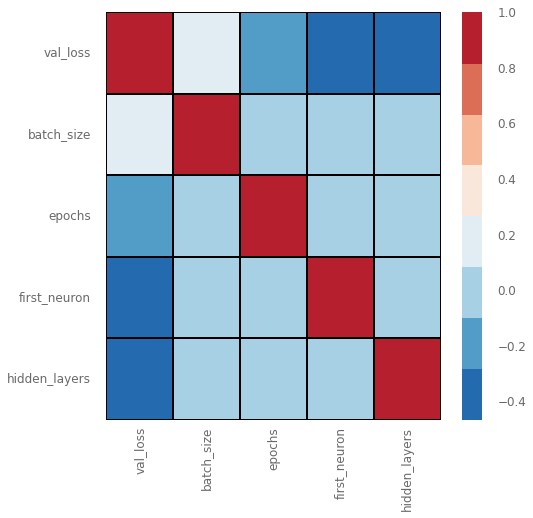

In [ ]:
# get a correlation plot for hyperparameters against a metric 
r.plot_corr('val_loss', ['loss', 'val_loss', 'round_epochs'])
# plt.savefig('curve.png', dpi=1000)

In [ ]:
# Get the best model index with highest 'val_categorical_accuracy' 
model_id = scan_results_SimpleRNN.data['val_loss'].astype('float').argmin() - 0

* It is possible to retrieve the loss curve of the best model


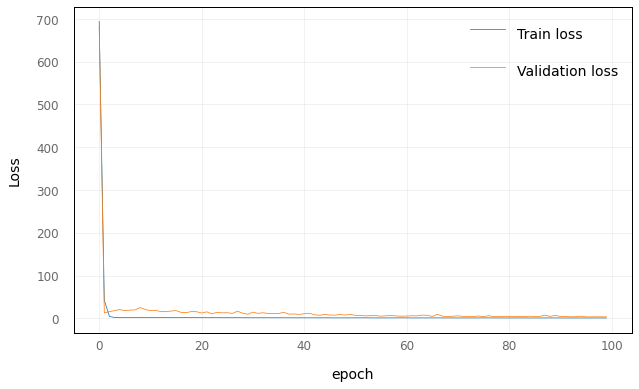

In [ ]:
model_history = scan_results_SimpleRNN.round_history[model_id]

# LOSS CURVE
# Plot train loss and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    # plt.show()


plot_loss(model_history)

In [ ]:
# Clear any previous TensorFlow session.
tf.keras.backend.clear_session()

# Load the model parameters from the scanner.
model = model_from_json(scan_results_SimpleRNN.saved_models[model_id])
model.set_weights(scan_results_SimpleRNN.saved_weights[model_id])
model.summary()
model.save('./best_model_GRU_single_Step')

# Load that model
# my_tf_saved_model = tf.keras.models.load_model('./saved_models/my_tf_model')
# my_tf_saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 32)            1248      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 32)            2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


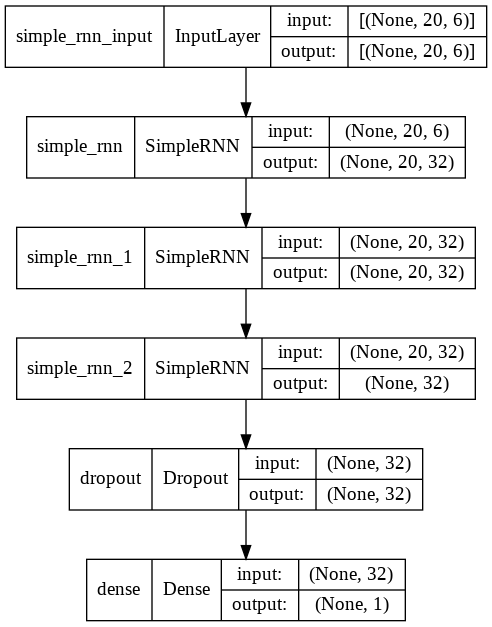

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    return prediction


prediction_simpleRNN = prediction(model)
# prediction_gru = prediction(model_gru)
# prediction_lstm = prediction(model_lstm)
# prediction_cnn_1d = prediction(model_cnn_1d)


In [ ]:
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Stock Price (€)')
    plt.savefig('Prediction_Evaluation_plot.png', dpi=1200)
    plt.show()


plot_future(prediction_simpleRNN, 'SimpleRNN', y_test)
# plot_future(prediction_gru, 'GRU', y_test)
# plot_future(prediction_lstm, 'LSTM', y_test)
# plot_future(prediction_cnn_1d, 'CNN_1D', y_test)

In [ ]:
# Define a function to calculate MAE and RSME
step_ahead=1
def evaluate_prediction(predicted, actual, model_name):
    if step_ahead == 1:
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(model_name + ' performance:')
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Root Mean Square Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return
    else:
        titles = ["RMSE", "MAE", "R^2"]
        # calculate an RMSE score for each day
        # calculate mse
        rmse = np.sqrt(mean_squared_error(predicted, actual, multioutput='raw_values'))
        mae = mean_absolute_error(predicted, actual, multioutput='raw_values')
        r2 = r2_score(predicted, actual, multioutput='raw_values')
        df_scores = pd.DataFrame(list(zip(rmse, mae, r2)), columns=[f'{x}' for x in titles])
        df_scores.index += 1

        colors = plt.rcParams["axes.prop_cycle"]()
        a = 1  # number of rows
        b = 3  # number of columns
        c = 1  # initialize plot counter
        fig = plt.figure(figsize=(15, 6))
        for i in titles:
            plt.subplot(a, b, c)
            plt.title(f'{i}')
            next_colour = next(colors)["color"]
            df_scores[f'{i}'].plot(marker='o', color=next_colour)
            plt.xticks((range(0, df_scores.shape[0] + 1)))
            plt.legend(loc='upper left')
            plt.xlabel('Forecast Range (Day)')
            plt.ylabel(f'{i}')
            c = c + 1

        plt.subplots_adjust(.5)
        fig.suptitle("Evaluation of performances' trend in the multi step forecasted range", fontsize=16, y=1)
        plt.tight_layout()
        # plt.savefig('EvaluationMultiplePrediction_PG.png', dpi=1200)
        plt.show()

        # calculate overall RMSE
        overall_rmse = np.sqrt(mean_squared_error(predicted, actual, multioutput='uniform_average'))
        overall_mae = mean_absolute_error(predicted, actual, multioutput='uniform_average')
        overall_r2 = r2_score(predicted, actual, multioutput='uniform_average')
        print(model_name + ' performance:')
        print('R^2: {:.4f} %'.format(overall_r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(overall_mae))
        print('Root Mean Square Error: {:.4f}'.format(overall_rmse))
        print('')
        return


evaluate_prediction(prediction_simpleRNN, y_test, 'SimpleRNN')
# evaluate_prediction(prediction_gru, y_test, 'GRU')
# evaluate_prediction(prediction_lstm, y_test, 'LSTM')
# evaluate_prediction(prediction_cnn_1d, y_test, 'CNN_1D')